In [1]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

In [2]:
import matplotlib
%matplotlib notebook

In [3]:
import numpy as np 
import cPickle as pkl
from matplotlib import pyplot as plt
import pandas as pd
from theano_time_corex import *
import linearcorex
from generate_data import *
import vis_utils
import metric_utils
import random
import baselines

# Load Data

### some arguments

In [5]:
nt = 4
nv = 128
train_cnt = 48
val_cnt = 16
test_cnt = 16
data_type='stock_week'  # 'stock_day'
start_date='2000-01-01'
end_date='2018-01-01'

In [42]:
import random

def load_stock_data_bad_way(nt, nv, train_cnt, val_cnt, test_cnt, data_type='stock_day',
                            start_date='2000-01-01', end_date='2018-01-01', stride='one'):
    random.seed(42)
    np.random.seed(42)

    print("Loading stock data ...")
    if data_type == 'stock_week':
        with open('../data/EOD_week.pkl', 'rb') as f:
            df = pd.DataFrame(pkl.load(f))
    elif data_type == 'stock_day':
        with open('../data/EOD_day.pkl', 'rb') as f:
            df = pd.DataFrame(pkl.load(f))
    else:
        raise ValueError("Unrecognized value '{}' for data_type variable".format(data_type))
    df = df[df.index >= start_date]
    df = df[df.index <= end_date]

    # shuffle the columns
    cols = sorted(list(df.columns))
    random.shuffle(cols)
    df = df[cols]

    train_data = []
    val_data = []
    test_data = []

    window = train_cnt + val_cnt + test_cnt
    if stride == 'one':
        indices = range(window, len(df) - window)
    if stride == 'full':
        indices = range(window, len(df) - window, window + 1)
    assert len(indices) >= nt

    for i in indices:
        start = i - window
        end = i + window + 1
        perm = range(2 * window + 1)
        random.shuffle(perm)

        part = np.array(df[start:end])
        assert len(part) == 2 * window + 1

        train_data.append(part[perm[:train_cnt]])
        val_data.append(part[perm[train_cnt:train_cnt + val_cnt]])
        test_data.append(part[perm[-test_cnt:]])

    # take last nt time steps
    train_data = np.array(train_data[-nt:])
    val_data = np.array(val_data[-nt:])
    test_data = np.array(test_data[-nt:])

    # add small gaussian noise
    noise_var = 1e-7
    noise_myu = np.zeros((train_data.shape[-1],))
    noise_cov = np.diag([noise_var] * train_data.shape[-1])
    train_data += np.random.multivariate_normal(noise_myu, noise_cov, size=train_data.shape[:-1])
    val_data += np.random.multivariate_normal(noise_myu, noise_cov, size=val_data.shape[:-1])
    test_data += np.random.multivariate_normal(noise_myu, noise_cov, size=test_data.shape[:-1])

    # find valid variables
    valid_stocks = []
    for i in range(train_data.shape[-1]):
        ok = True
        for t in range(train_data.shape[0]):
            if np.var(train_data[t, :, i]) > 1e-2:
                ok = False
                break
        if ok:
            valid_stocks.append(i)

    # select nv valid variables
    print("\tremained {} variables".format(len(valid_stocks)))
    assert len(valid_stocks) >= nv
    valid_stocks = valid_stocks[:nv]
    train_data = train_data[:, :, valid_stocks]
    val_data = val_data[:, :, valid_stocks]
    test_data = test_data[:, :, valid_stocks]

    # scale the data (this is needed for T-GLASSO to work)
#     coef = np.sqrt(np.var(train_data, axis=0).mean())
#     train_data = train_data / coef
#     val_data = val_data / coef
#     test_data = test_data / coef

    print('Stock data is loaded:')
    print('\ttrain shape:', train_data.shape)
    print('\tval   shape:', val_data.shape)
    print('\ttest  shape:', test_data.shape)

    return train_data, val_data, test_data


In [6]:
# load data (bad way)
train_data, val_data, test_data = load_stock_data_bad_way(nt=nt, nv=nv, train_cnt=train_cnt,
                                                  val_cnt=val_cnt, test_cnt=test_cnt,
                                                  data_type=data_type, stride='full',
                                                  start_date=start_date, end_date=end_date)

print('train shape:', np.array(train_data).shape)
print('val   shape:', np.array(val_data).shape)
print('test  shape:', np.array(test_data).shape)

NameError: name 'load_stock_data_bad_way' is not defined

In [7]:
# load data (good way)
train_data, val_data, test_data = load_stock_data(nt=nt, nv=nv, train_cnt=train_cnt,
                                                  val_cnt=val_cnt, test_cnt=test_cnt,
                                                  data_type=data_type, stride='full',
                                                  start_date=start_date, end_date=end_date)

print('train shape:', np.array(train_data).shape)
print('val   shape:', np.array(val_data).shape)
print('test  shape:', np.array(test_data).shape)

Loading stock data ...
	remained 4338 variables
Stock data is loaded:
	train shape: (4, 48, 128)
	val   shape: (4, 16, 128)
	test  shape: (4, 16, 128)
train shape: (4, 48, 128)
val   shape: (4, 16, 128)
test  shape: (4, 16, 128)


<IPython.core.display.Javascript object>


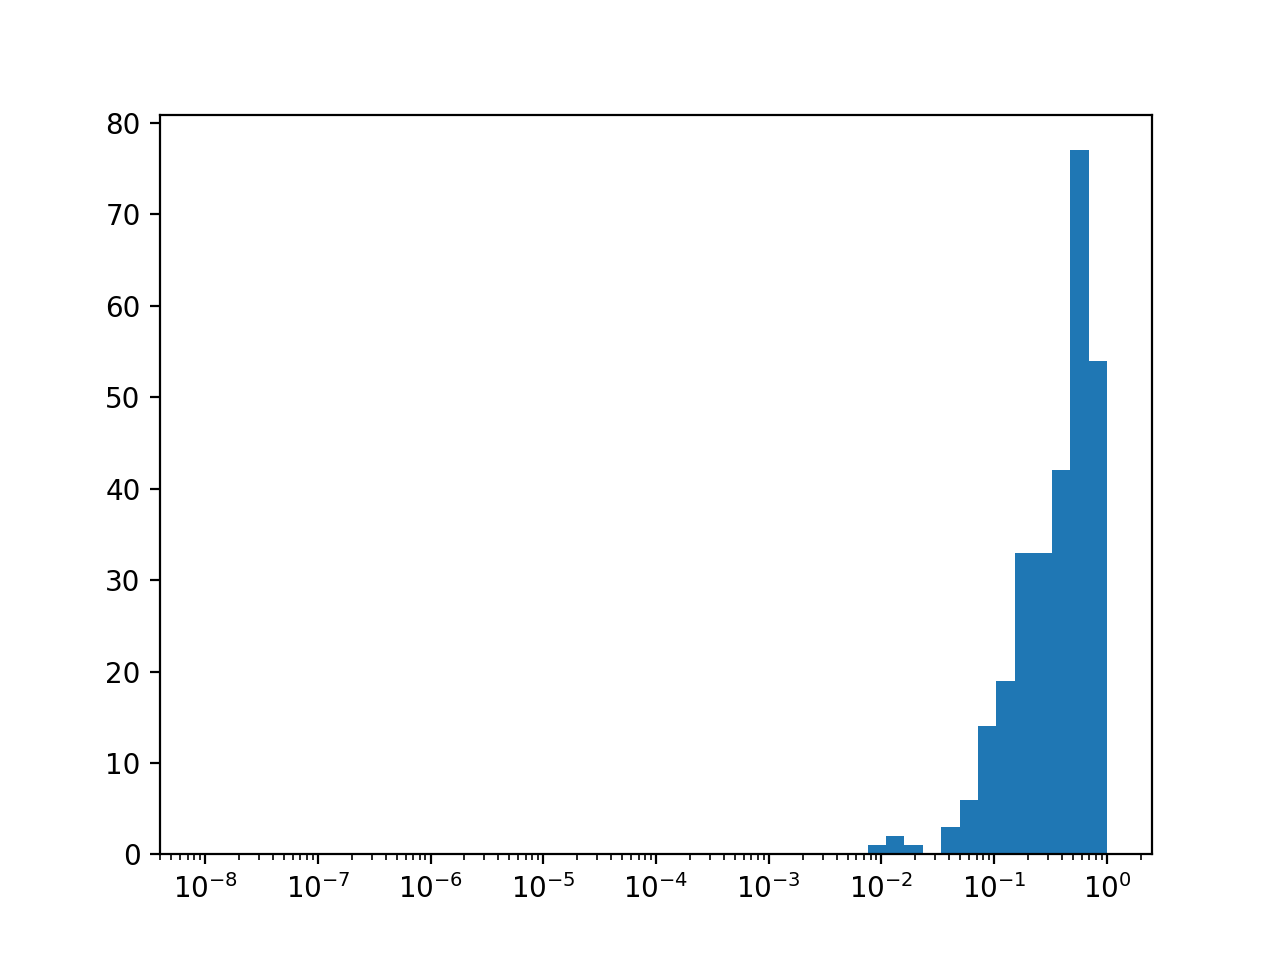

In [8]:
all_vars = []
for t in range(nt):
    all_vars += list(np.var(train_data[t], axis=0))
plt.figure()
plt.hist(all_vars, bins=np.logspace(np.log10(1e-8),np.log10(1.0), 50))
plt.gca().set_xscale("log")

In [7]:
"""
indices = []
for i in range(1000):
    ok = True
    for t in range(nt):
        if np.var(train_data[t][:, i]) > 1e-2:
            ok = False
            break
#     for t in range(nt):
#         if not (1e-8 < np.var(train_data[t][:, i]) < 1e-3):
#             ok = False
#             break
    if ok:
        indices.append(i)

train_data = [x[:, indices] for x in train_data]
val_data = [x[:, indices] for x in val_data]
test_data = [x[:, indices] for x in test_data]
print("Remained {} variables".format(len(indices)))
nv = min(len(indices), 64)

train_data = [x[:, :nv] for x in train_data]
val_data = [x[:, :nv] for x in val_data]
test_data = [x[:, :nv] for x in test_data]

print('train shape:', np.array(train_data).shape)
print('val   shape:', np.array(val_data).shape)
print('test  shape:', np.array(test_data).shape)
"""

'\nindices = []\nfor i in range(1000):\n    ok = True\n    for t in range(nt):\n        if np.var(train_data[t][:, i]) > 1e-2:\n            ok = False\n            break\n#     for t in range(nt):\n#         if not (1e-8 < np.var(train_data[t][:, i]) < 1e-3):\n#             ok = False\n#             break\n    if ok:\n        indices.append(i)\n\ntrain_data = [x[:, indices] for x in train_data]\nval_data = [x[:, indices] for x in val_data]\ntest_data = [x[:, indices] for x in test_data]\nprint("Remained {} variables".format(len(indices)))\nnv = min(len(indices), 64)\n\ntrain_data = [x[:, :nv] for x in train_data]\nval_data = [x[:, :nv] for x in val_data]\ntest_data = [x[:, :nv] for x in test_data]\n\nprint(\'train shape:\', np.array(train_data).shape)\nprint(\'val   shape:\', np.array(val_data).shape)\nprint(\'test  shape:\', np.array(test_data).shape)\n'

### scale

In [8]:
"""
# coef = 100.0
coef = 1.0 / np.sqrt( np.var( np.concatenate(train_data, axis=0).reshape((-1, nv)), axis=0 ).mean() )
train_data = [x * coef for x in train_data]
val_data = [x * coef for x in val_data]
test_data = [x * coef for x in test_data]
"""

'\n# coef = 100.0\ncoef = 1.0 / np.sqrt( np.var( np.concatenate(train_data, axis=0).reshape((-1, nv)), axis=0 ).mean() )\ntrain_data = [x * coef for x in train_data]\nval_data = [x * coef for x in val_data]\ntest_data = [x * coef for x in test_data]\n'

### add some noise

In [9]:
"""
# for t in range(nt):
#     var = np.var(train_data[t], axis=0)
#     train_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag(var) * 1.0, size=train_data[t].shape[:-1])
#     val_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag(var) * 1.0, size=val_data[t].shape[:-1])
#     test_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag(var) * 1.0, size=test_data[t].shape[:-1])
    
for t in range(nt):
    var = np.var(train_data[t], axis=0)
    train_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag([1e-5]*nv), size=train_data[t].shape[:-1])
    val_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag([1e-5]*nv), size=val_data[t].shape[:-1])
    test_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag([1e-5]*nv), size=test_data[t].shape[:-1])
        
    
print('train shape:', np.array(train_data).shape)
print('val   shape:', np.array(val_data).shape)
print('test  shape:', np.array(test_data).shape)
"""

"\n# for t in range(nt):\n#     var = np.var(train_data[t], axis=0)\n#     train_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag(var) * 1.0, size=train_data[t].shape[:-1])\n#     val_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag(var) * 1.0, size=val_data[t].shape[:-1])\n#     test_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag(var) * 1.0, size=test_data[t].shape[:-1])\n    \nfor t in range(nt):\n    var = np.var(train_data[t], axis=0)\n    train_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag([1e-5]*nv), size=train_data[t].shape[:-1])\n    val_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag([1e-5]*nv), size=val_data[t].shape[:-1])\n    test_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag([1e-5]*nv), size=test_data[t].shape[:-1])\n        \n    \nprint('train shape:', np.array(train_data).shape)\nprint('val   shape:', np.array(val_data).shape)\nprint('test  shape:', np.array(te

### standardize

In [10]:
"""
means = [np.mean(x, axis=0) for x in train_data]
stds = [np.sqrt(np.var(x, axis=0)) for x in train_data]

train_data = [(x - m) / s for x,m,s in zip(train_data, means, stds)]
val_data = [(x - m) / s for x,m,s in zip(val_data, means, stds)]
test_data = [(x - m) / s for x,m,s in zip(test_data, means, stds)]

print('train shape:', np.array(train_data).shape)
print('val   shape:', np.array(val_data).shape)
print('test  shape:', np.array(test_data).shape)
"""

"\nmeans = [np.mean(x, axis=0) for x in train_data]\nstds = [np.sqrt(np.var(x, axis=0)) for x in train_data]\n\ntrain_data = [(x - m) / s for x,m,s in zip(train_data, means, stds)]\nval_data = [(x - m) / s for x,m,s in zip(val_data, means, stds)]\ntest_data = [(x - m) / s for x,m,s in zip(test_data, means, stds)]\n\nprint('train shape:', np.array(train_data).shape)\nprint('val   shape:', np.array(val_data).shape)\nprint('test  shape:', np.array(test_data).shape)\n"

In [11]:
"""
for t in range(nt):
    plt.figure()
    plt.plot(np.var(train_data[t], axis=0))
    plt.show()
"""

'\nfor t in range(nt):\n    plt.figure()\n    plt.plot(np.var(train_data[t], axis=0))\n    plt.show()\n'

# Baselines

In [9]:
nhidden_grid = [8, 16, 32]
tcorex_gamma_grid = [1.25, 1.5, 2.0, 3.0, 4.0]

methods = [
    (baselines.Diagonal(name='Diagonal'), {}),

    (baselines.LedoitWolf(name='Ledoit-Wolf'), {}),

    (baselines.OAS(name='Oracle approximating shrinkage'), {}),

    (baselines.PCA(name='PCA'), {'n_components': nhidden_grid}),

    (baselines.FactorAnalysis(name='Factor Analysis'), {'n_components': nhidden_grid}),
    
    (baselines.LinearCorex(name='Linear CorEx (applied bucket-wise)'), {
        'n_hidden': nhidden_grid,
        'max_iter': 500,
        'anneal': True}),

    (baselines.LinearCorexWholeData(name='Linear CorEx (applied on whole data)'), {
        'n_hidden': nhidden_grid,
        'max_iter': 500,
        'anneal': True}),

    (baselines.GraphLasso(name='Graphical LASSO (sklearn)'), {
        'alpha': [0.003, 0.01, 0.03, 0.1, 0.3, 1.0],
        'mode': 'lars',
        'max_iter': 100}),

    (baselines.TimeVaryingGraphLasso(name='T-GLASSO'), {
        'lamb': [0.01, 0.03, 0.1, 0.3],
        'beta': [0.03, 0.1, 0.3, 1.0],
        'indexOfPenalty': [1],  # TODO: extend grid of this one; NOTE: L2 is slow and not efficient
        'max_iter': 100}),

    (baselines.TimeVaryingGraphLasso(name='T-GLASSO (no reg)'), {
        'lamb': [0.003, 0.01, 0.03, 0.1, 0.3, 1.0],
        'beta': [0.0],
        'indexOfPenalty': [1],
        'max_iter': 100}),

    (baselines.TCorex(tcorex=TCorex, name='T-Corex (W)'), {
        'nv': nv,
        'n_hidden': nhidden_grid,
        'max_iter': 500,
        'anneal': True,
        'reg_params': {
            'l2': [],
            'l1': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        },
        'reg_type': 'W'
    }),

    (baselines.TCorex(tcorex=TCorexWeights, name='T-Corex (W, weighted samples, no reg)'), {
        'nv': nv,
        'n_hidden': nhidden_grid,
        'max_iter': 500,
        'anneal': True,
        'l1': [0.0],
        'l2': 0.0,
        'gamma': tcorex_gamma_grid,
        'reg_type': 'W',
        'init': True
    }),

    (baselines.TCorex(tcorex=TCorexWeights, name='T-Corex (W, weighted samples)'), {
        'nv': nv,
        'n_hidden': nhidden_grid,
        'max_iter': 500,
        'anneal': True,
        'reg_params': {
            # 'l1': [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0],
            'l1': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
            'l2': [],
        },
        'gamma': tcorex_gamma_grid,
        'reg_type': 'W',
        'init': True
    })
]

0.0117455150029


<IPython.core.display.Javascript object>


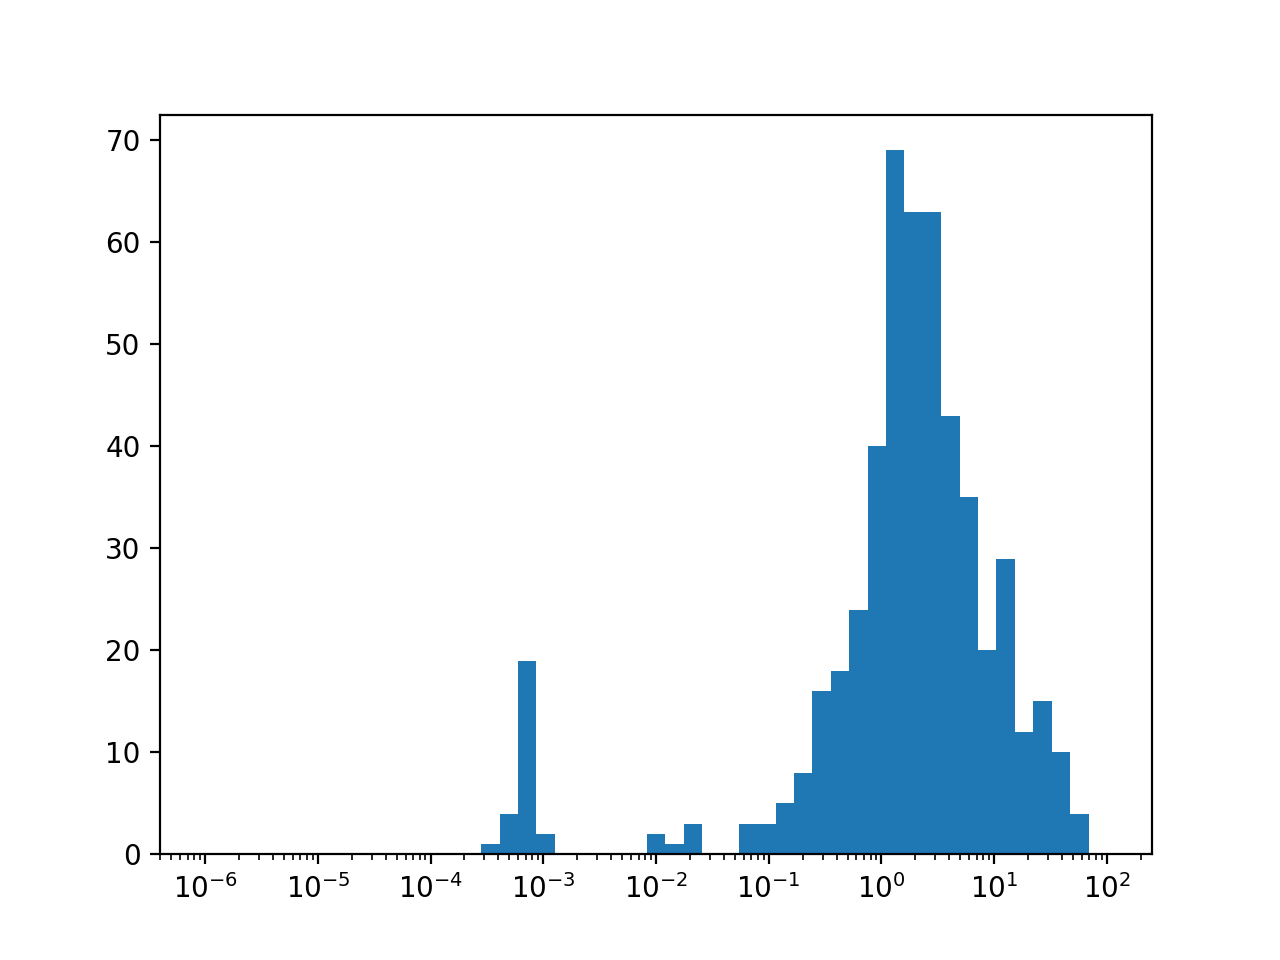

In [45]:
coef = np.median(np.sqrt(np.var(train_data, axis=0).flatten()))
print(coef)
scaled_train_data = train_data / coef
scaled_val_data = val_data / coef
scaled_test_data = test_data / coef

all_vars = []
for t in range(nt):
    all_vars += list(np.var(scaled_train_data[t], axis=0))
plt.figure()
plt.hist(all_vars, bins=np.logspace(np.log10(1e-6),np.log10(100.0), 50))
plt.gca().set_xscale("log")

## Diagonal


--------------------------------------------------------------------------------
Selecting the best parameter values for Diagonal ...
done 0 / 1 | running with 
Training Diagonal ...
	Elapsed time 0.0s
	current score: 178.766325914

Finished with best validation score: 178.766325914
Evaluating Diagonal ...
	Score: 193.0184


<IPython.core.display.Javascript object>


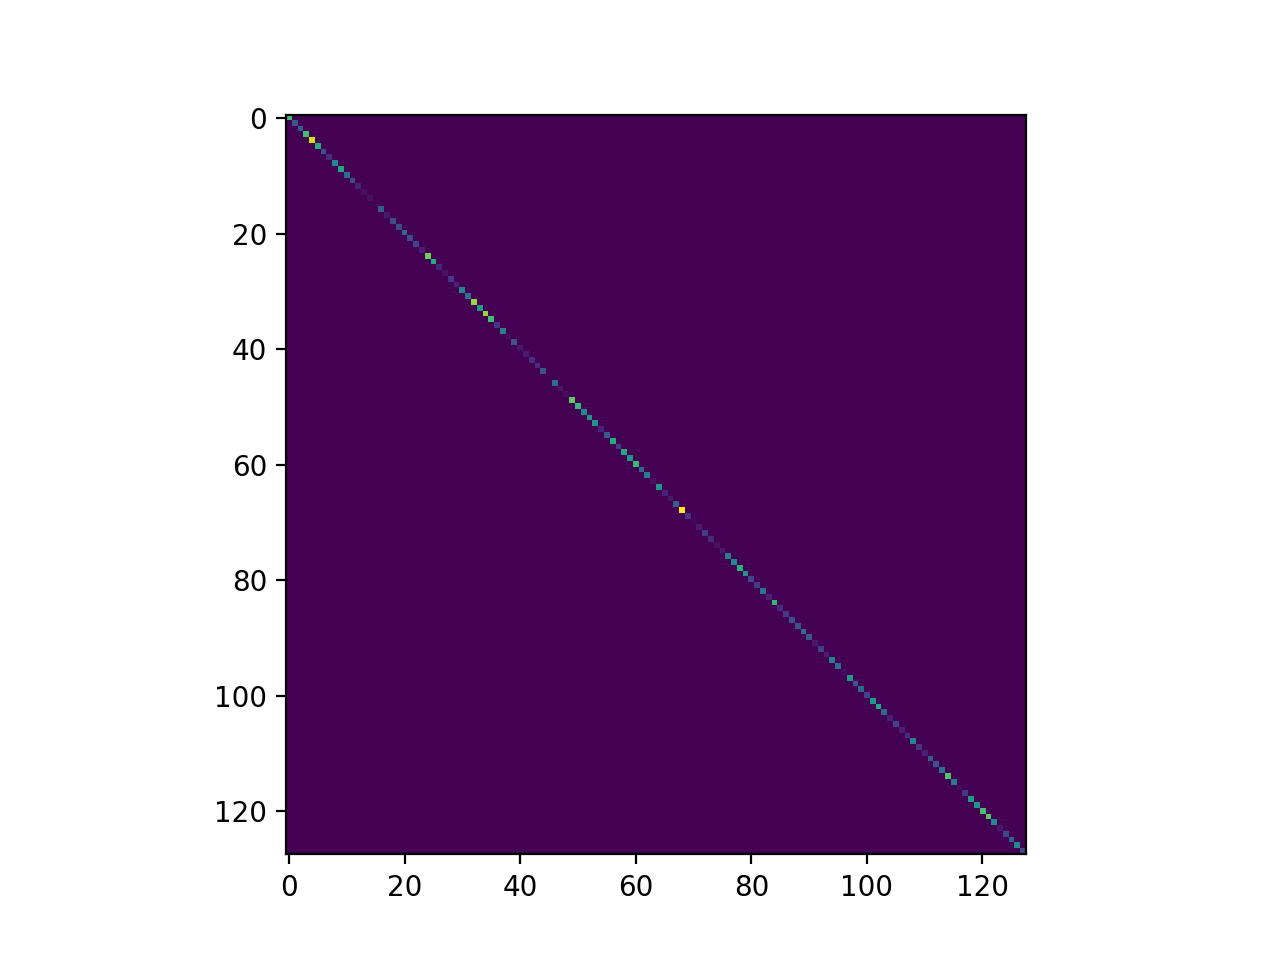

In [10]:
diag = methods[0]
diag_best_score, diag_best_params, diag_covs, _ = diag[0].select(train_data, val_data, diag[1])
diag[0].evaluate(test_data)

plt.figure()
plt.imshow(diag_covs[0])
plt.show()


--------------------------------------------------------------------------------
Selecting the best parameter values for Diagonal ...
done 0 / 1 | running with 
Training Diagonal ...
	Elapsed time 0.0s
	current score: 213.85636685

Finished with best validation score: 213.85636685
Evaluating Diagonal ...
	Score: 228.7179


<IPython.core.display.Javascript object>


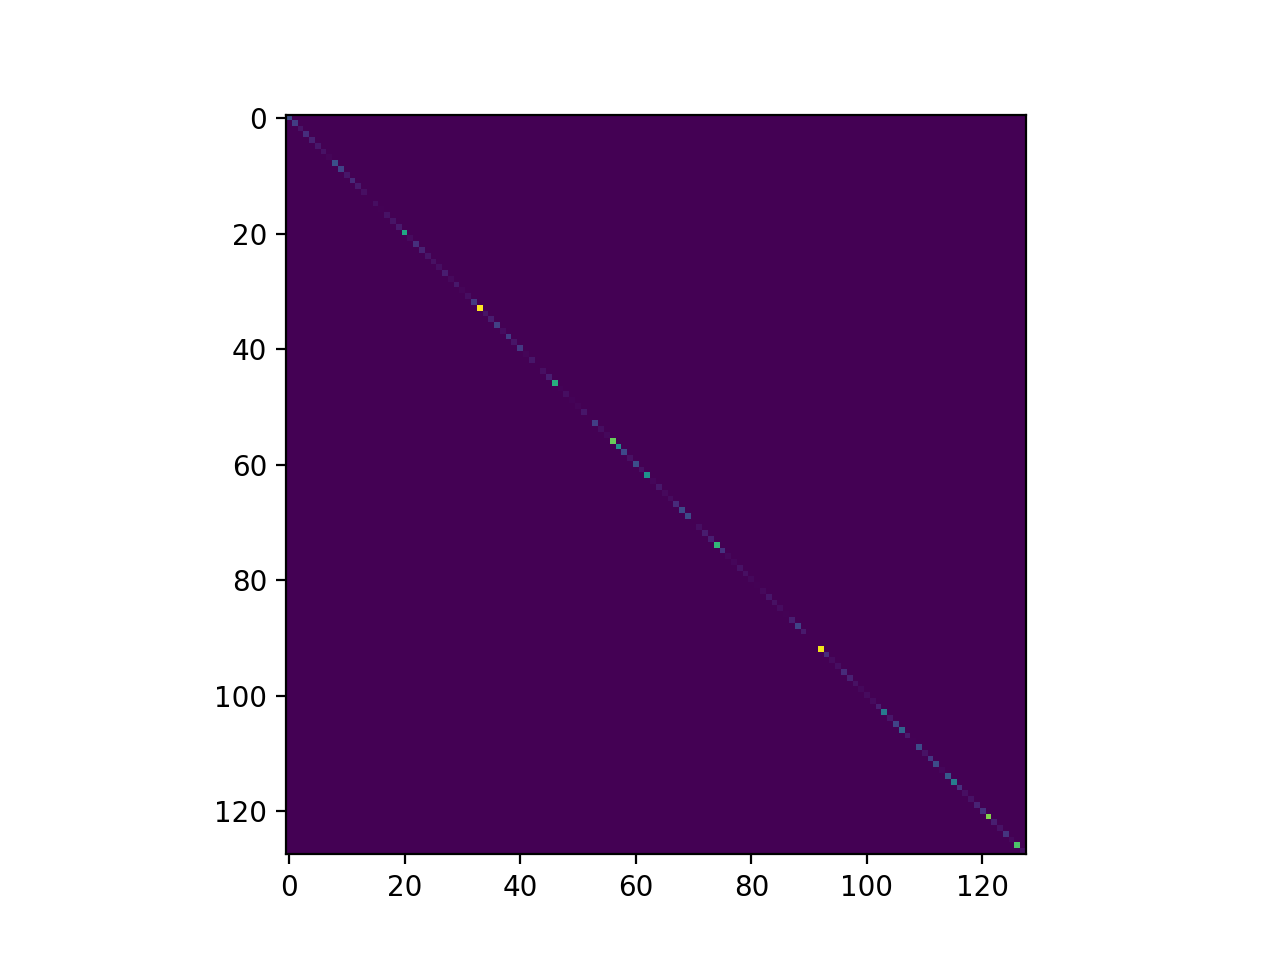

In [47]:
diag = methods[0]
diag_best_score, diag_best_params, diag_covs, _ = diag[0].select(scaled_train_data, scaled_val_data, diag[1])
diag[0].evaluate(scaled_test_data)

plt.figure()
plt.imshow(diag_covs[0])
plt.show()

## T-GLASSO


--------------------------------------------------------------------------------
Selecting the best parameter values for T-GLASSO (no reg) ...
done 0 / 1 | running with lamb: 1	beta: 0.0	
Training T-GLASSO (no reg) ...
Use l-1 penalty function
4
lambda = 1, beta = 0.0
	Elapsed time 36.5s
	current score: 173.879660069

Finished with best validation score: 173.879660069
Evaluating T-GLASSO (no reg) ...
	Score: 184.2282


<IPython.core.display.Javascript object>


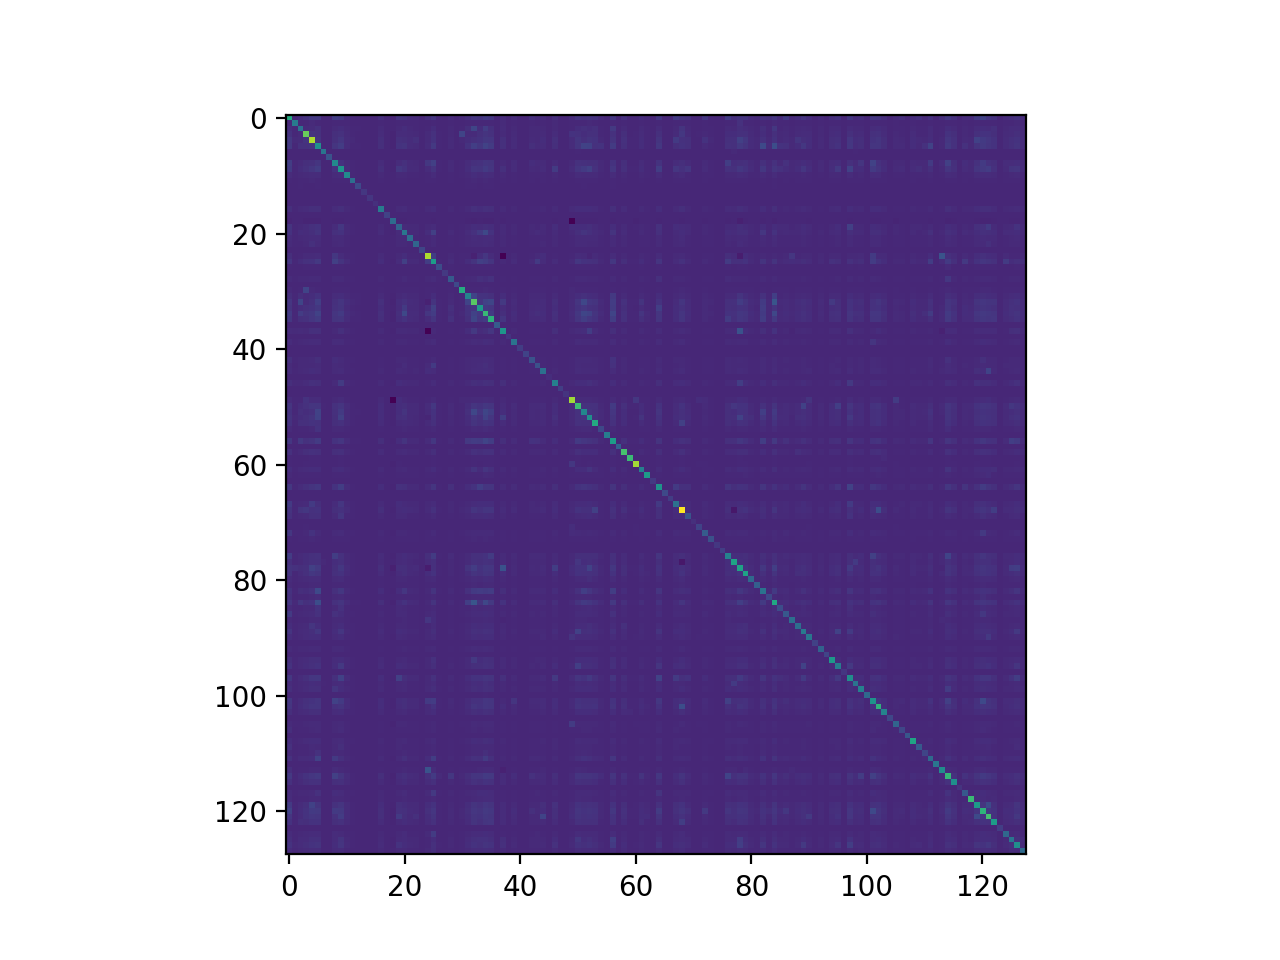

In [11]:
tg_noreg = methods[-4]
tg_noreg[1]['lamb'] = [1]
tg_noreg[1]['indexOfPenalty'] = 1
tg_noreg[1]['max_iter'] = 100
tg_noreg[1]['beta'] = [0.0]
tg_noreg_best_score, tg_noreg_best_params, tg_noreg_covs, _ = tg_noreg[0].select(train_data, val_data, tg_noreg[1])
tg_noreg[0].evaluate(test_data)

plt.figure()
plt.imshow(tg_noreg_covs[0])
plt.show()


--------------------------------------------------------------------------------
Selecting the best parameter values for T-GLASSO (no reg) ...
done 0 / 1 | running with lamb: 1	beta: 0.0	
Training T-GLASSO (no reg) ...
Use l-1 penalty function
4
lambda = 1, beta = 0.0
	Elapsed time 120.8s
	current score: 220.869609939

Finished with best validation score: 220.869609939
Evaluating T-GLASSO (no reg) ...
	Score: 234.1253


<IPython.core.display.Javascript object>


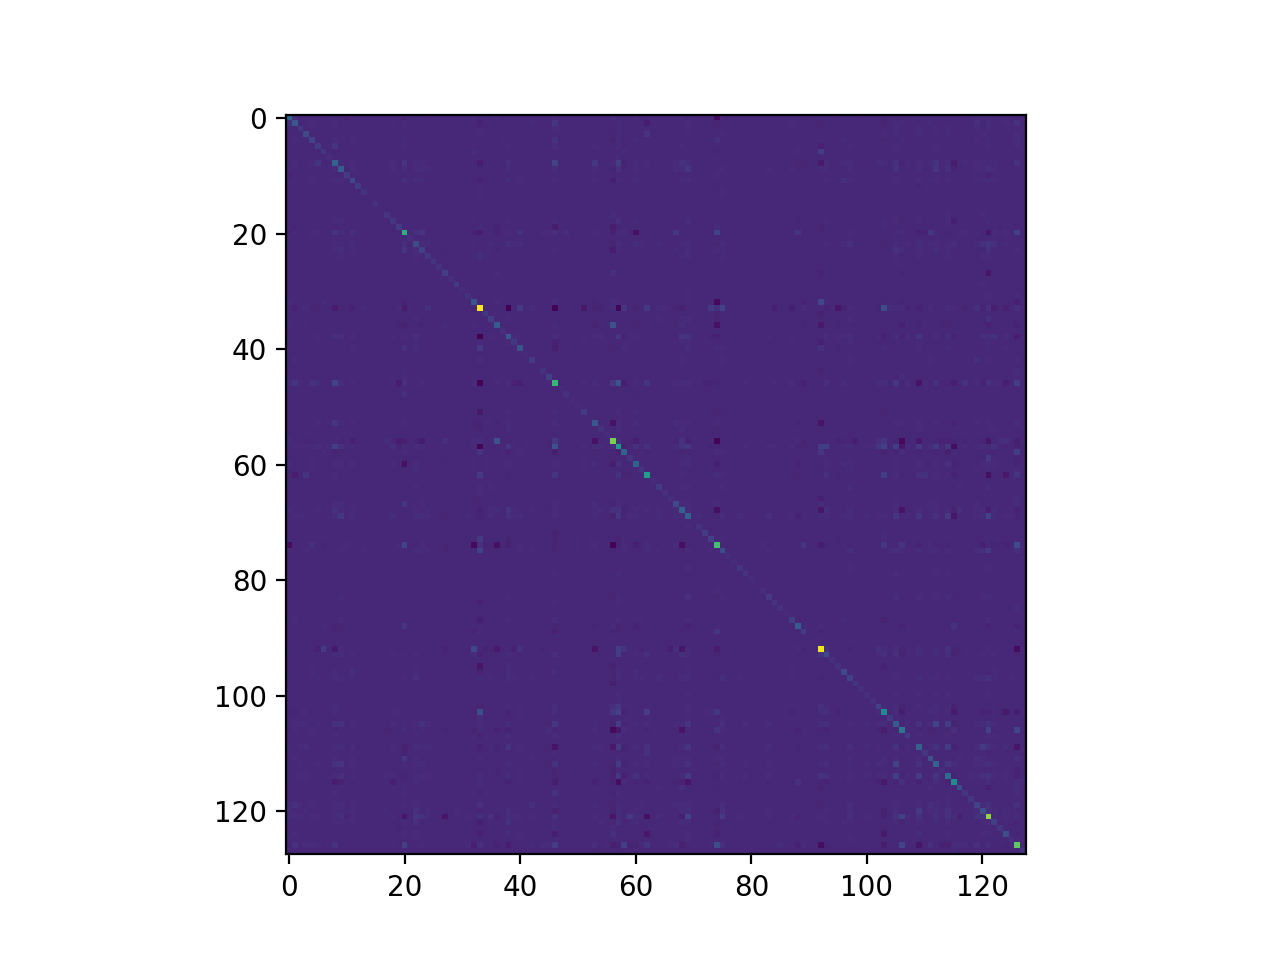

In [54]:
tg_noreg = methods[-4]
tg_noreg[1]['lamb'] = [1]
tg_noreg[1]['indexOfPenalty'] = 1
tg_noreg[1]['max_iter'] = 100
tg_noreg[1]['beta'] = [0.0]
tg_noreg_best_score, tg_noreg_best_params, tg_noreg_covs, _ = tg_noreg[0].select(scaled_train_data, scaled_val_data, tg_noreg[1])
tg_noreg[0].evaluate(scaled_test_data)

plt.figure()
plt.imshow(tg_noreg_covs[0])
plt.show()

## Ledoit-Wolf


--------------------------------------------------------------------------------
Selecting the best parameter values for Ledoit-Wolf ...
done 0 / 1 | running with 
Training Ledoit-Wolf ...
	Elapsed time 0.0s
	current score: 192.54212307

Finished with best validation score: 192.54212307
Evaluating Ledoit-Wolf ...
	Score: 203.6598


<IPython.core.display.Javascript object>


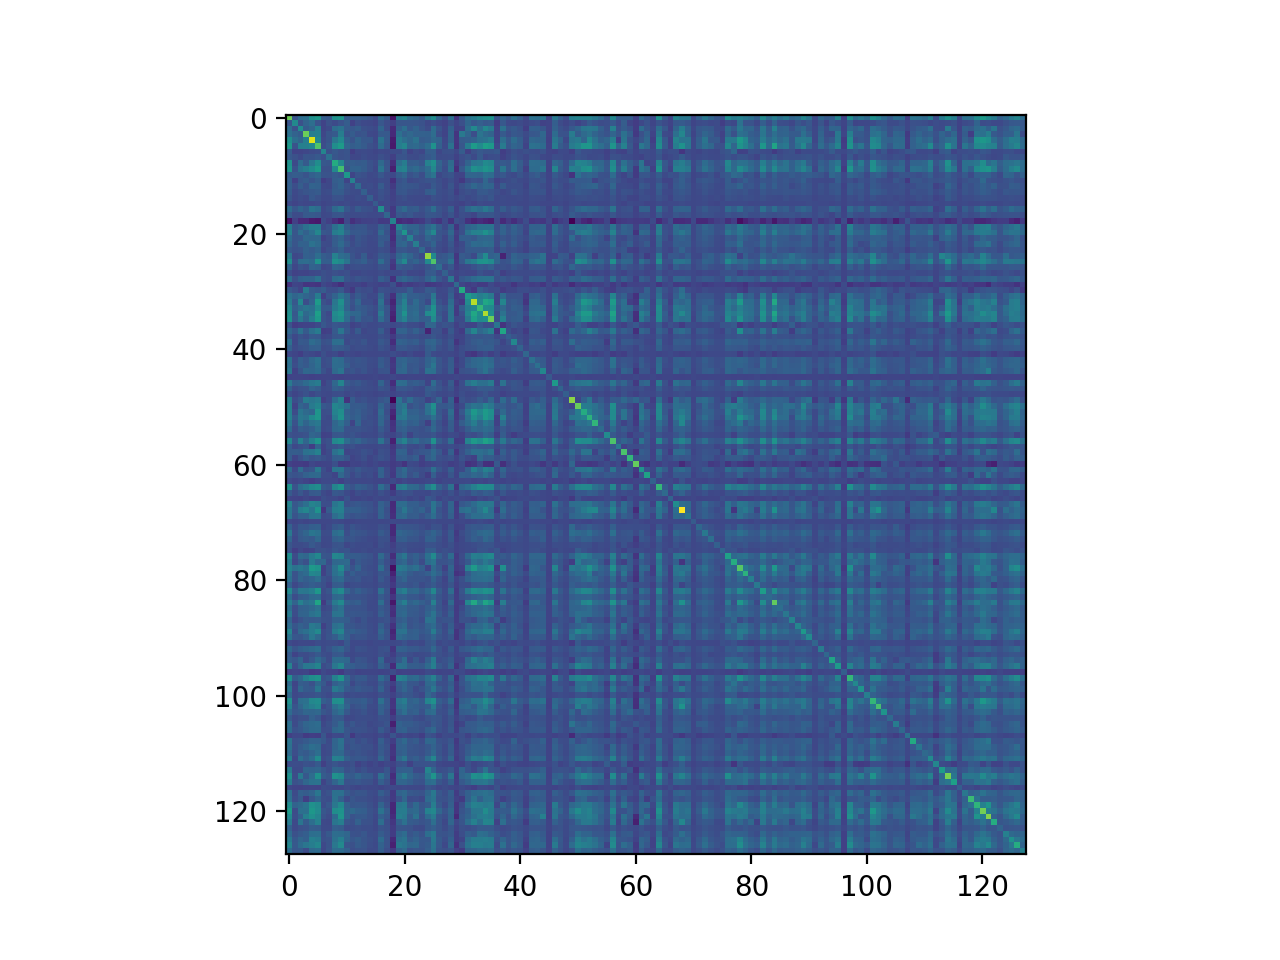

In [12]:
lw = methods[1]
lw_best_score, lw_best_params, lw_covs, _ = lw[0].select(train_data, val_data, lw[1])
lw[0].evaluate(test_data)

plt.figure()
plt.imshow(lw_covs[0])
plt.show()


--------------------------------------------------------------------------------
Selecting the best parameter values for Ledoit-Wolf ...
done 0 / 1 | running with 
Training Ledoit-Wolf ...
	Elapsed time 0.2s
	current score: 253.729695521

Finished with best validation score: 253.729695521
Evaluating Ledoit-Wolf ...
	Score: 261.8647


<IPython.core.display.Javascript object>


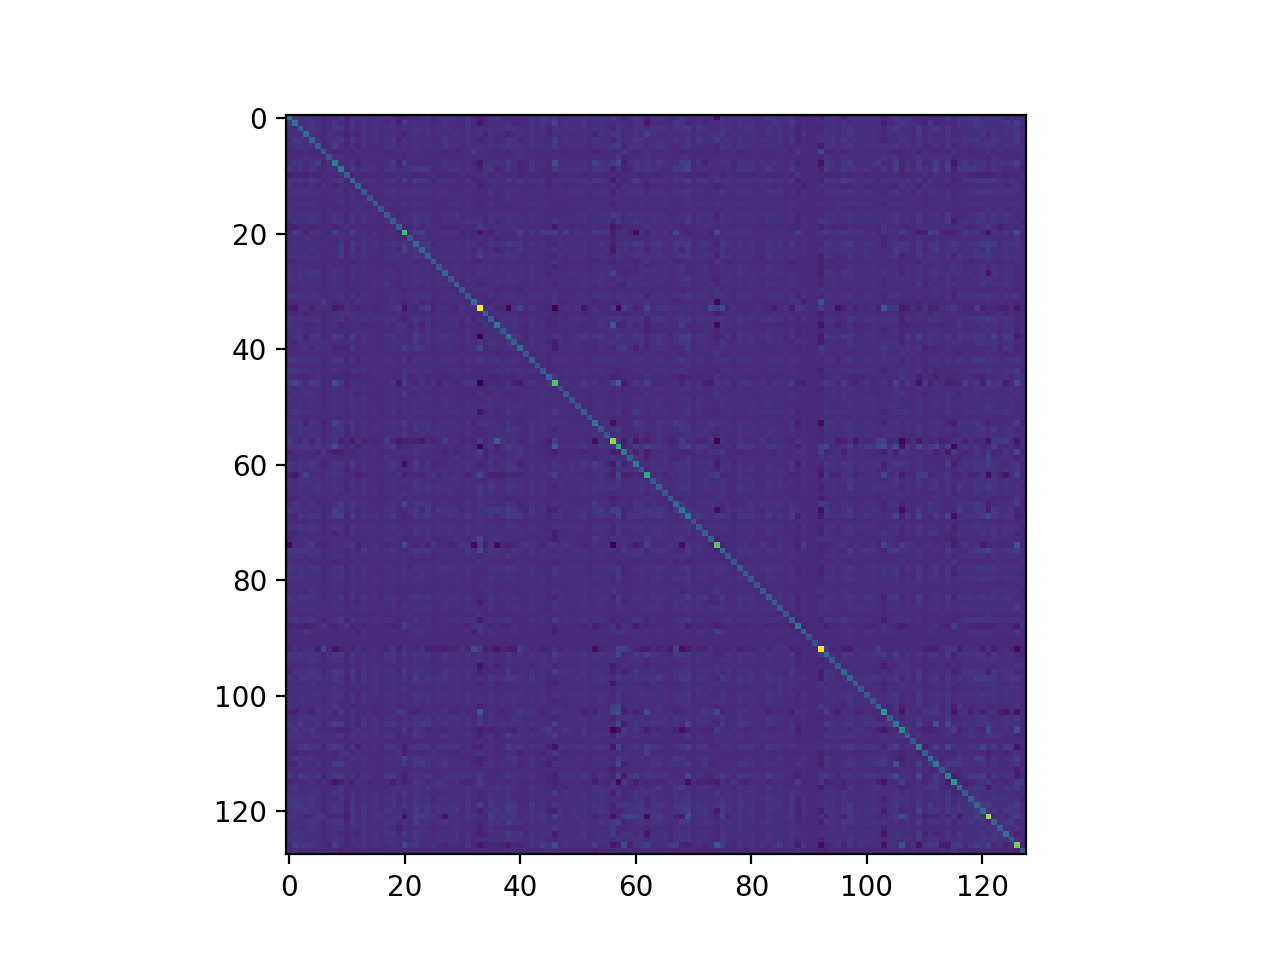

In [51]:
lw = methods[1]
lw_best_score, lw_best_params, lw_covs, _ = lw[0].select(scaled_train_data, scaled_val_data, lw[1])
lw[0].evaluate(scaled_test_data)

plt.figure()
plt.imshow(lw_covs[0])
plt.show()

## GLASSO (from sklearn)


--------------------------------------------------------------------------------
Selecting the best parameter values for Graphical LASSO (sklearn) ...
done 0 / 7 | running with alpha: 1e-06	
Training Graphical LASSO (sklearn) ...
	Graphical LASSO (sklearn) failed with message: Non SPD result: the system is too ill-conditioned for this solver
	Elapsed time 0.2s
	current score: inf
done 1 / 7 | running with alpha: 0.003	
Training Graphical LASSO (sklearn) ...
	Graphical LASSO (sklearn) failed with message: Non SPD result: the system is too ill-conditioned for this solver
	Elapsed time 0.1s
	current score: inf
done 2 / 7 | running with alpha: 0.01	
Training Graphical LASSO (sklearn) ...
	Graphical LASSO (sklearn) failed with message: Non SPD result: the system is too ill-conditioned for this solver
	Elapsed time 0.2s
	current score: inf
done 3 / 7 | running with alpha: 0.03	
Training Graphical LASSO (sklearn) ...
	Graphical LASSO (sklearn) failed with message: Non SPD result: the system 

/home/harhrayr/miniconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: -4.981e-02
  ConvergenceWarning)
/home/harhrayr/miniconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: 3.549e-03
  ConvergenceWarning)


	Elapsed time 6.1s
	current score: 174.763586726
done 5 / 7 | running with alpha: 0.3	
Training Graphical LASSO (sklearn) ...
	Graphical LASSO (sklearn) failed with message: Non SPD result: the system is too ill-conditioned for this solver
	Elapsed time 0.1s
	current score: inf
done 6 / 7 | running with alpha: 1.0	
Training Graphical LASSO (sklearn) ...


/home/harhrayr/miniconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: -2.263e-04
  ConvergenceWarning)


	Elapsed time 1.4s
	current score: 173.508178759

Finished with best validation score: 173.508178759
Evaluating Graphical LASSO (sklearn) ...
	Score: 182.1276


<IPython.core.display.Javascript object>


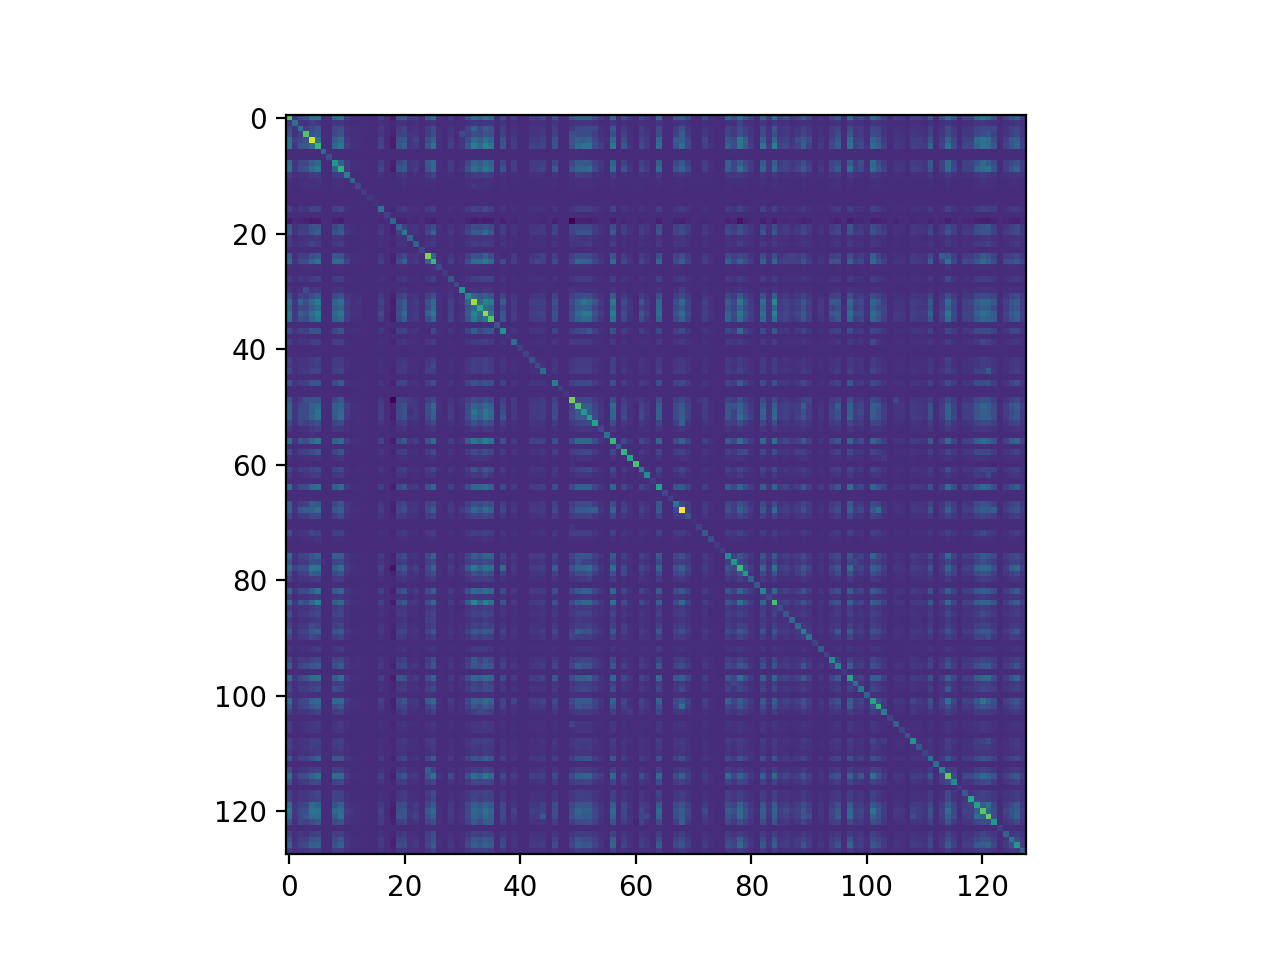

In [14]:
gsk = methods[7]
gsk[1]['alpha'] = [1e-6, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
gsk_best_score, gsk_best_params, gsk_covs, _ = gsk[0].select(train_data, val_data, gsk[1])
gsk[0].evaluate(test_data)

plt.figure()
plt.imshow(gsk_covs[0])
plt.show()

In [13]:
gsk = methods[7]
gsk[1]['alpha'] = [1e-6, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
gsk_best_score, gsk_best_params, gsk_covs, _ = gsk[0].select(scaled_train_data, scaled_val_data, gsk[1])
gsk[0].evaluate(scaled_test_data)

plt.figure()
plt.imshow(gsk_covs[0])
plt.show()

NameError: name 'scaled_train_data' is not defined

# T-CorEx

In [ ]:
tcorex = methods[-1]
tcorex_best_score, tcorex_best_params, tcorex_covs, _ = tcorex[0].select(train_data, val_data, tcorex[1])
tcorex[0].evaluate(test_data)

plt.figure()
plt.imshow(tcorex_covs[0])
plt.show()